In [65]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# You must download the following data sets:
# Images: http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# Annotation: http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

# Lab Assignment Two: Exploring Image Data
Machine Learning in Python<br/>
Diogo Benetti Faé Rodrigues<br/>
Alex Shockley<br/>
Jay Kynerd<br/>
02/21/2023

**[2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data.**

## Business Understanding

#### Our dataset is a massive repository of different dog breeds. We are given the image data of the dog, the cropped version that contains just the pixels where the dog is (will be explained visually later in the notebook) and the label that we are looking to predict (the actual breed of the dog). It is important to note that not all of the dogs are the same resolution nor are they all looking the same way(some are looking at the camera, some are looking to the side). Our prediciton task is to predict what the breed of a dog is based on an image of the dog. One potential use case for this would be for pounds to be able to quickly identify what breed a dog is, or at least get a first opinion on it. This dataset is also serving as a general exploritory case for us to learn how image data is processed. 

**[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.<br/>
[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).<br/>
[.1 points] Visualize several images.**

## Data Preparation

#### Before we start with some Data Reduction techniques, we must first read and prepare the data so it is ready to be used. The Stanford Dogs Dataset comes with 2 folders: Images and Annotation. Both have 120 folders inside of them, with the ID and name of each breed. The Images folder holds the actual dog images, and the Annotation folder contains information regarding where the dog is located in each image. This data is stored in XML.<br/>
#### The first step is to crop the images so that image is focused only on the the dogs, removing background noise.<br/>
#### The image at index 14558 is read with different value ranges and has 4 columns, instead of three. The fourth column is likely the alpha value. The data points seem to be already standardized, but since we don't know how it was standardized, it is best to drop that one image out of 20,580.

In [69]:
%%time
# About 50 s

# Receives breed and name of dog picture and
# returns cropped image focused on the dog
# Function adapted from https://www.kaggle.com/code/gabrielloye/dogs-inception-pytorch-implementation/notebook
def crop_dog(breed, dog):
    img = plt.imread(f'{os.getcwd()}/Images/{breed}/{dog}.jpg')
    tree = ET.parse(f'{os.getcwd()}/Annotation/{breed}/{dog}')
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img[ymin:ymax, xmin:xmax, :]
    return img

dogs = []   # List of all the images stored as numpy arrays (matrices) in RGB
i = 0
targets = []
for breed in os.listdir(f'{os.getcwd()}/Images'):
    curr_breed = breed
    # Uncomment to see progress
    # print(curr_breed, ' - ', i)
    for dog in os.listdir(f'{os.getcwd()}/Images/{breed}'):
        img = crop_dog(curr_breed, dog.split('.', 1)[0])
        dogs.append(img)
        targets.append(curr_breed.split('-',1)[1])

# Delete the weird image
del dogs[14558]
del targets[14558]

CPU times: user 25.5 s, sys: 3.17 s, total: 28.7 s
Wall time: 39.2 s


##### Below, we can see the difference between the original picture and the new picture that focuses on the dogs.

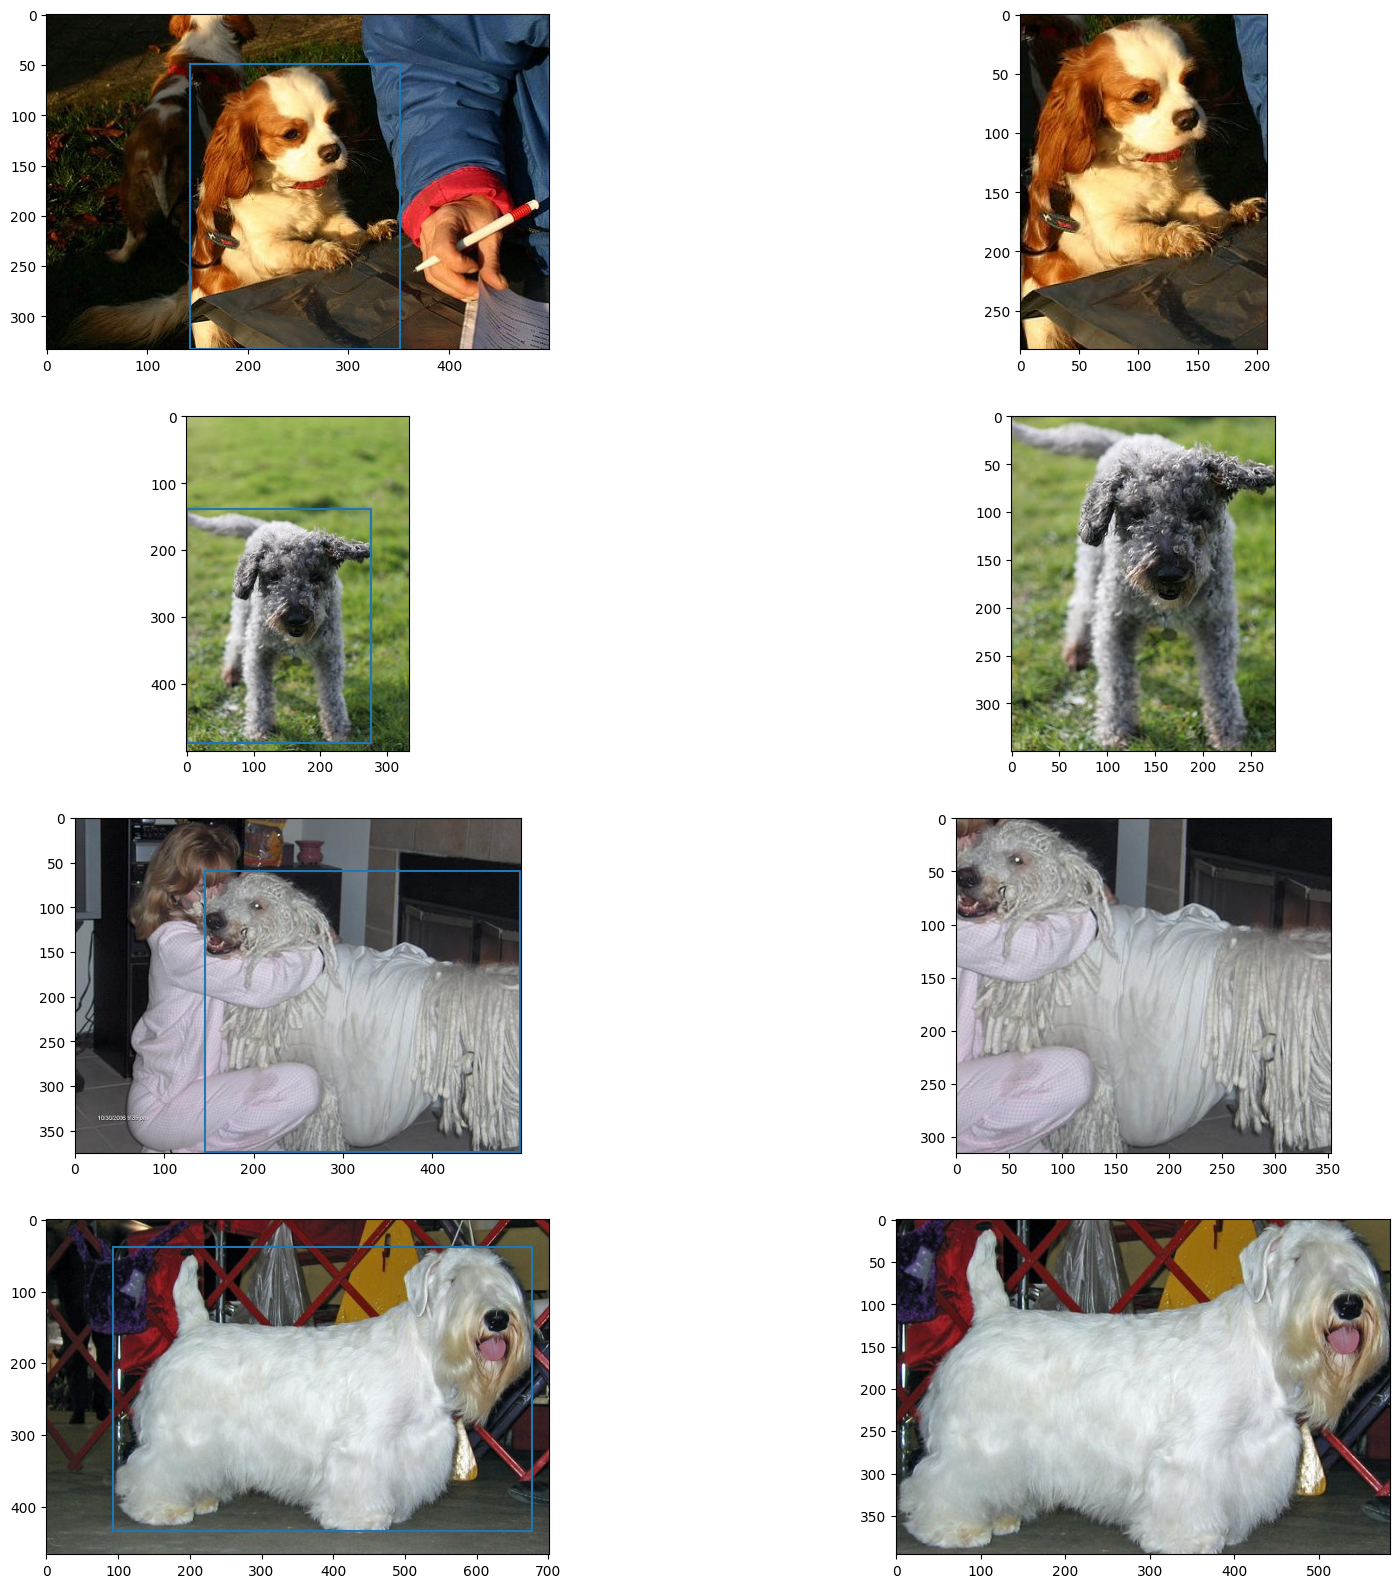

In [70]:
# Code adapted from https://www.kaggle.com/code/gabrielloye/dogs-inception-pytorch-implementation/notebook
Images_path = f'{os.getcwd()}/Images/'
Ann_path = f'{os.getcwd()}/Annotation/'
breed_list = os.listdir(Images_path)

plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(421 + (i*2))
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(Ann_path + breed))
    img = plt.imread(Images_path + breed + '/' + dog + '.jpg')
    plt.imshow(img)  
    
    tree = ET.parse(Ann_path + breed + '/' + dog)
    # Figure out the vertices of the box
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    # Plot Original Image with box on top
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    # Crop the image to the dimensions of the box
    crop_img = crop_dog(breed, dog)
    # Plot the cropped image
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)

#### After removing the background noise, we must transform the images so that they all have the same dimensions. The images must have the same sizes so that they can be standardized. We will not be converting the images into grayscale because the colors of the dogs are an important factor when identifying their breeds.

In [71]:
%%time
# About 45 s

# Resize Images into new list
i = 0
dogs_resized = []
for img in dogs:
    temp = Image.fromarray(dogs[i])                 # Read as an Image type
    temp_arr = np.array(temp.resize((150, 150)))    # Resize and cast as numpy array
    dogs_resized.append(np.ravel(temp_arr))         # Vectorize and append to list
    i += 1



CPU times: user 33.1 s, sys: 4.47 s, total: 37.6 s
Wall time: 59.9 s


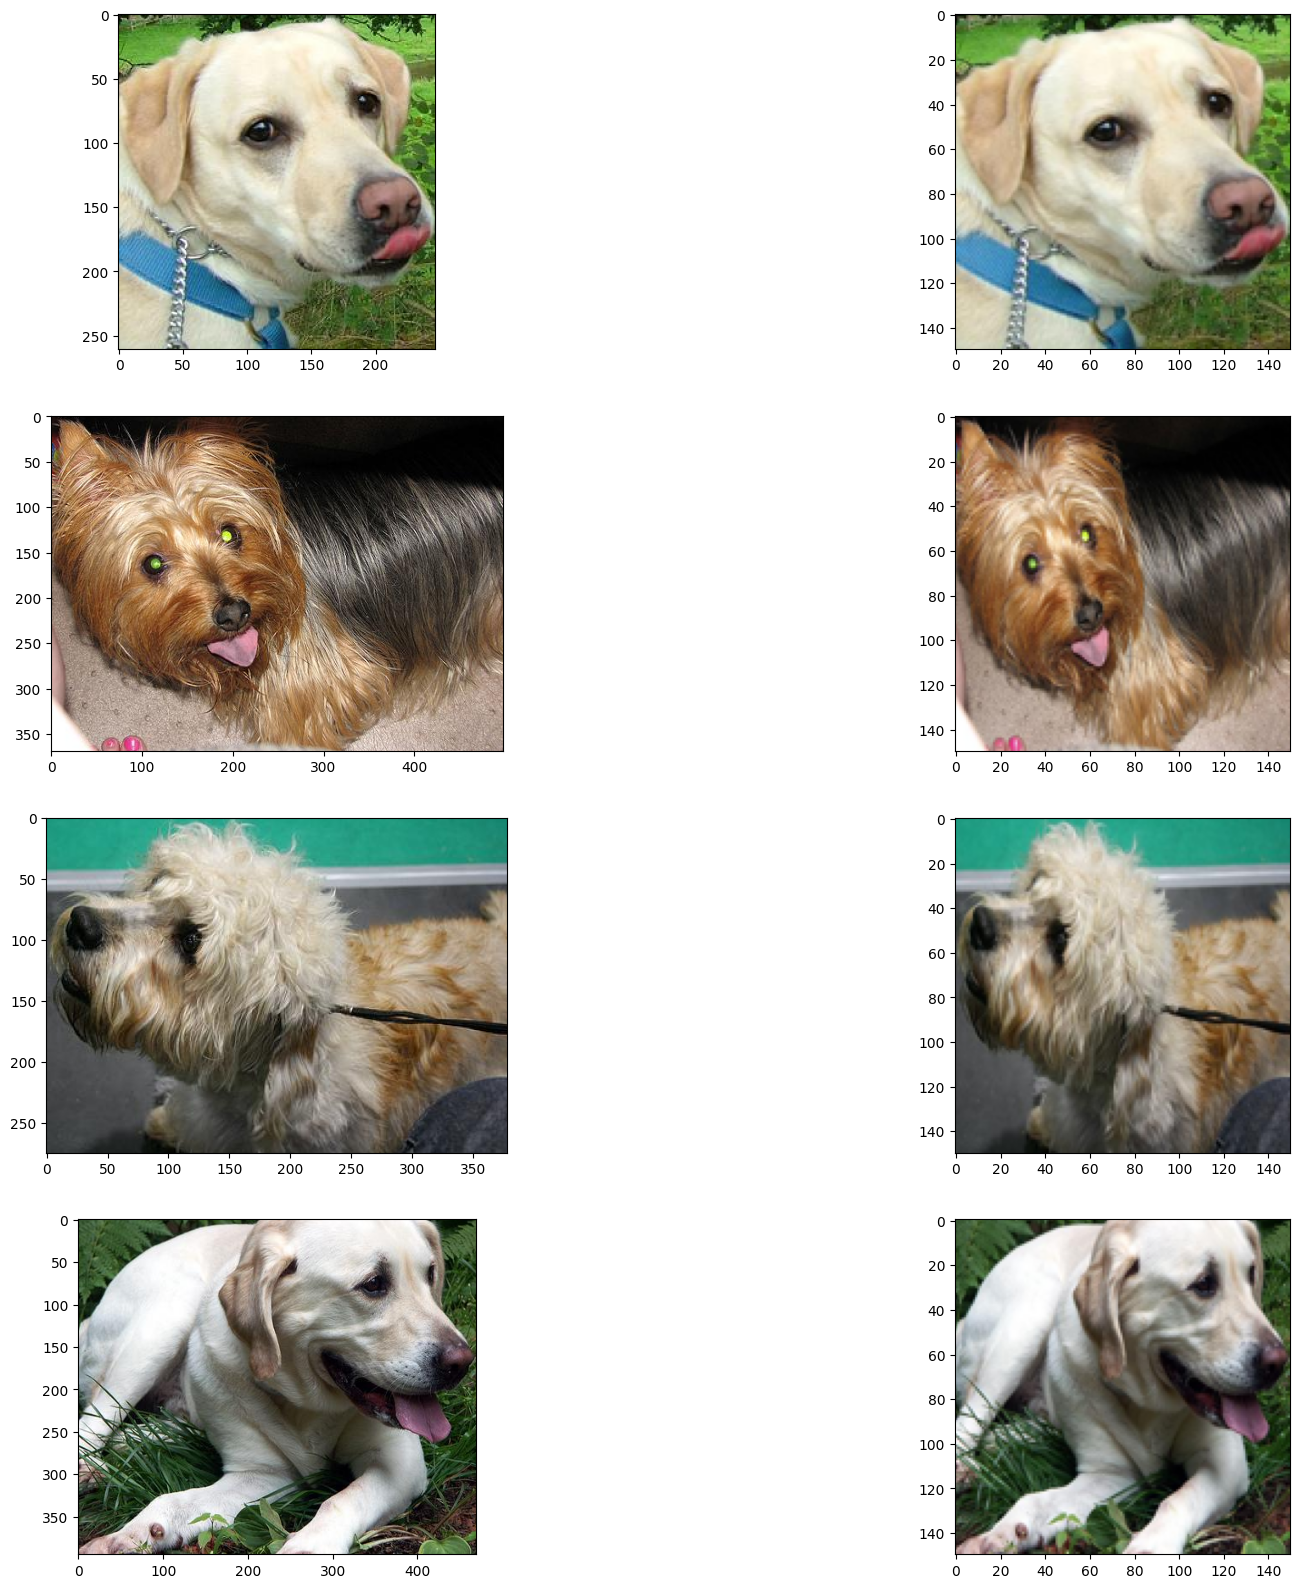

In [72]:
NUM_TO_SHOW = 4
indexes = np.random.choice(range(len(dogs_resized) -1),size=NUM_TO_SHOW)
plt.figure(figsize=(20, 20))
for count,value in enumerate(indexes):
    plt.subplot(NUM_TO_SHOW,2,(2 * count) + 1)
    plt.imshow(dogs[value])
    plt.subplot(NUM_TO_SHOW,2,(count + 1) * 2)
    plt.imshow(dogs_resized[value].reshape(150,150,3))


##### With all numpy arrays of the same size and vectorized, we can standardize the data so it is ready for Principal Component Analysis. Note that we decided to reduce the number of rows to 1000 for the sake of time in this project.

(1000,)
(20579, 67500)
(1000, 67500)
silky_terrier


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scaled Shape: (1000, 67500)
Indexes Shape: (4, 67500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 489 ms, sys: 894 ms, total: 1.38 s
Wall time: 3.61 s


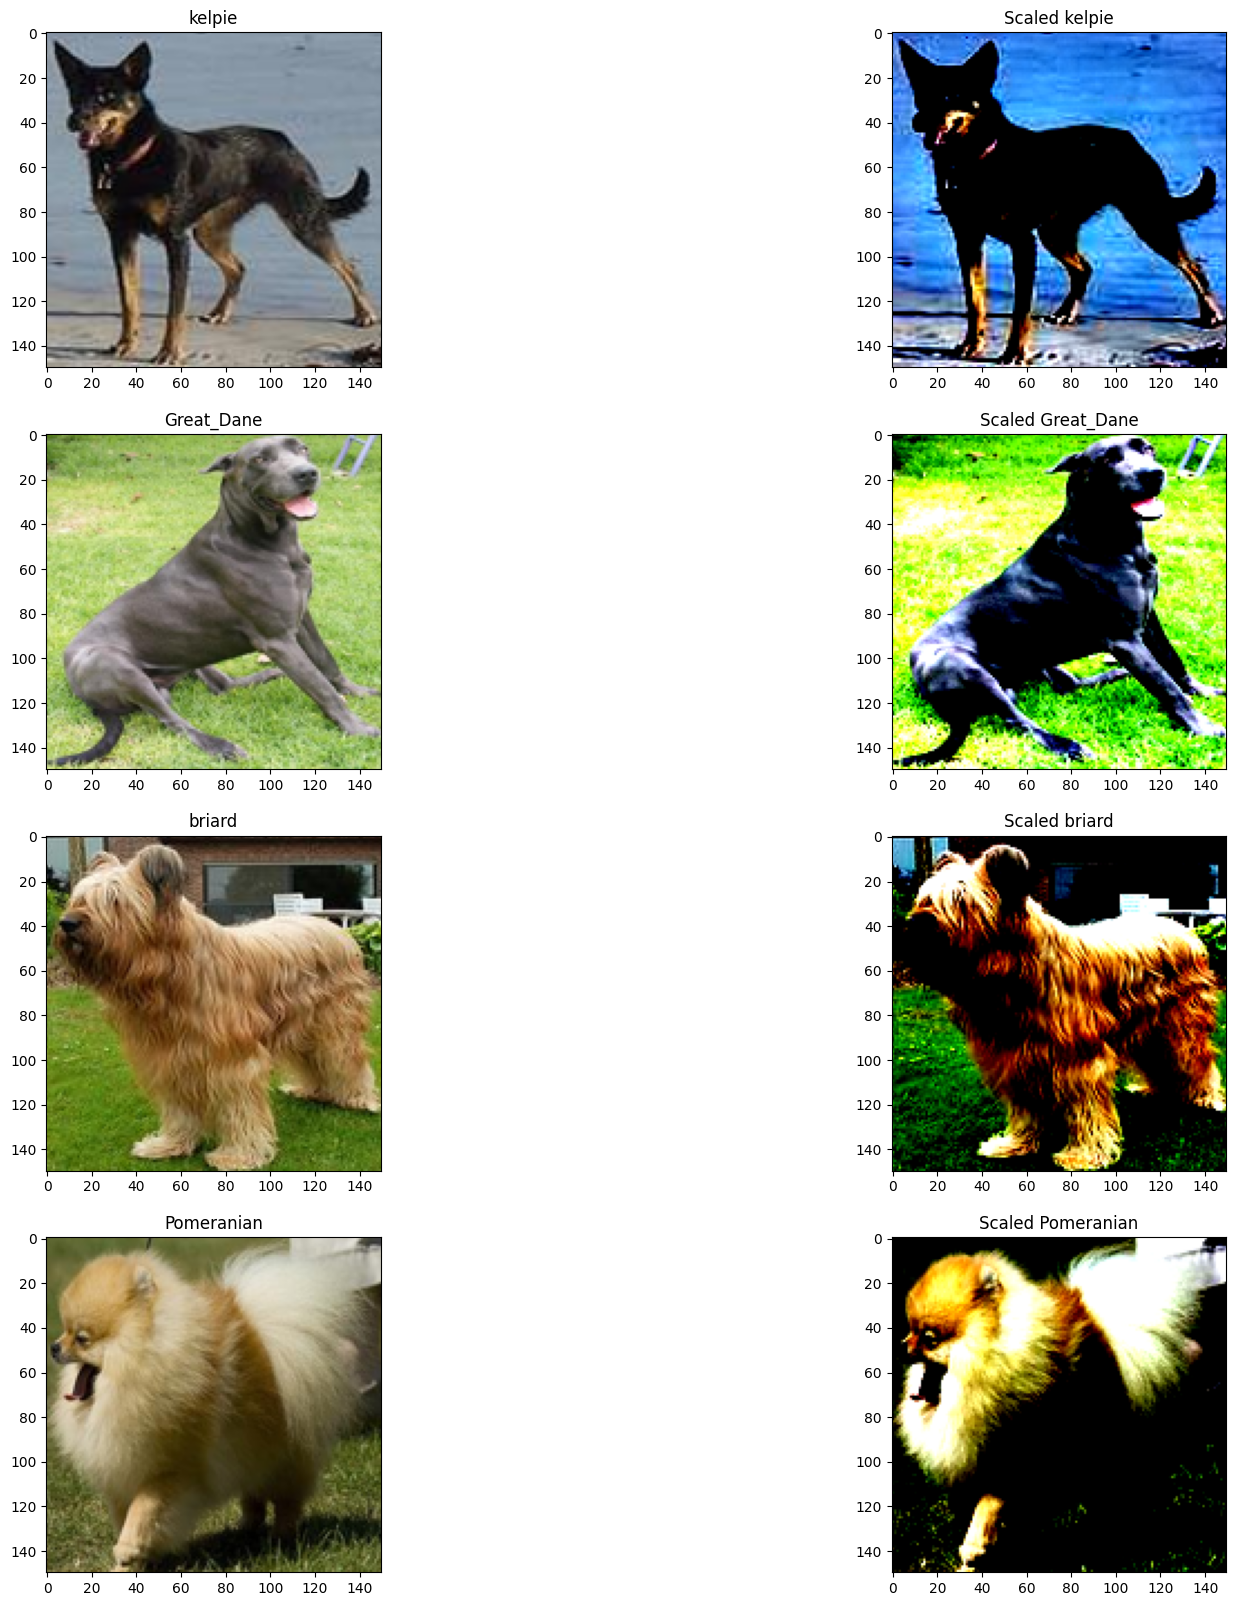

In [73]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
dogs_resized = np.array(dogs_resized)


NUM_ROWS_IN_SAMPLE = 1000
NUM_SCALED_DOGS = 4

indexer = np.random.randint(len(dogs_resized) - 1, size=NUM_ROWS_IN_SAMPLE)
targets = np.array(targets)

X = np.array(dogs_resized[indexer,:])
y = np.array(targets[indexer])
print(y.shape)
print(dogs_resized.shape)
print(X.shape)
print(y[0])




scaled = StandardScaler().fit_transform(X)

print(f"Scaled Shape: {scaled.shape}")
indexer_scaled = np.random.randint(len(X) - 1, size=NUM_SCALED_DOGS)

indexes = X[indexer_scaled,:]
the_labels = y[indexer_scaled]
scaled_indexes = scaled[indexer_scaled,:]

print(f"Indexes Shape: {indexes.shape}")

plt.figure(figsize=(20, 20))
for count,value in enumerate(indexes):
    plt.subplot(NUM_SCALED_DOGS,2,(2 * count) + 1)
    plt.title(the_labels[count])
    plt.imshow(indexes[count].reshape(150,150,3))
    plt.subplot(NUM_SCALED_DOGS,2,(count + 1) * 2)
    plt.title(f"Scaled {the_labels[count]}")
    plt.imshow(scaled_indexes[count].reshape(150,150,3))

#Convert from string names to int values (encoding)
y = LabelEncoder().fit_transform(y)



**[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.<br/>
[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.<br/>
[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?<br/>
[1 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).<br/>
[2 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.**

## Data Reduction

For the data reduction portion of this notebook, we will be using Principal Components Analysis (PCA) to reduce the number of attributes we will use and getting rid of the curse of dimensionality. 

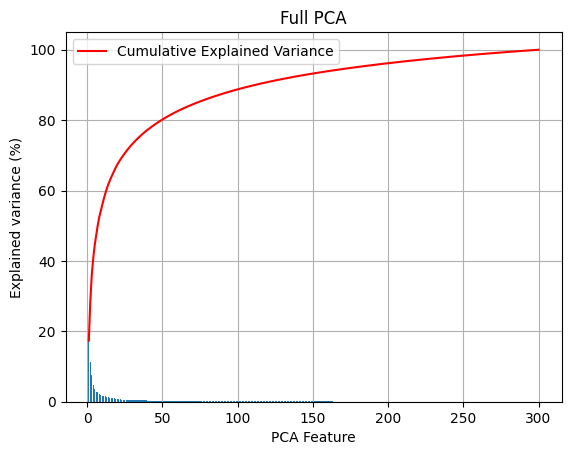

CPU times: user 2min 9s, sys: 12.3 s, total: 2min 21s
Wall time: 21.7 s


In [74]:
%%time

from numpy import mean
from numpy import std
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plot

def pca_describer(pca,title:str): #This function is used to graph the explained variance per component in any PCA object

    total_variance = np.sum(pca.explained_variance_)
    
    plt.bar(
        range(1,len(pca.explained_variance_)+1),
        [(x / total_variance) * 100 for x in pca.explained_variance_ ]
        )

    plt.plot(
        range(1,len(pca.explained_variance_ )+1),
        np.cumsum([(x / total_variance) * 100 for x in pca.explained_variance_ ]),
        c='red',
        label='Cumulative Explained Variance')
    
    plt.legend(loc='upper left')
    
    plt.xlabel('PCA Feature')
    plt.ylabel('Explained variance (%)')
    plt.title(title)

    plt.grid()
    plt.show()


NUM_COMPONENTS = 300



pca_full = PCA(n_components=NUM_COMPONENTS,svd_solver='full')
pca_full.fit(scaled)


pca_describer(pca_full,"Full PCA")


### Full PCA Analysis
Due to the possible number of components being in the 20,000 range, we decided to look at only a smaller subset of the components to determine the minimum number of components possible to describe most of the dataset. We chose 300 as the subset of components to look at, note that this number can be changed by altering the `NUM_COMPONENTS` variable, because it allowed us to do the PCA in a reasonable amount of time. We can determine that the number of components necessary to represent this data is around 100. This number was chosen because by going from 50-100, we gain roughly 10% variance, but by jumping from 100-150, we only gain about 5%. Since we want the fewest number of components that describe the highest % variance, we decided to take the loss of 5% variance and use 100 components instead of 150. 

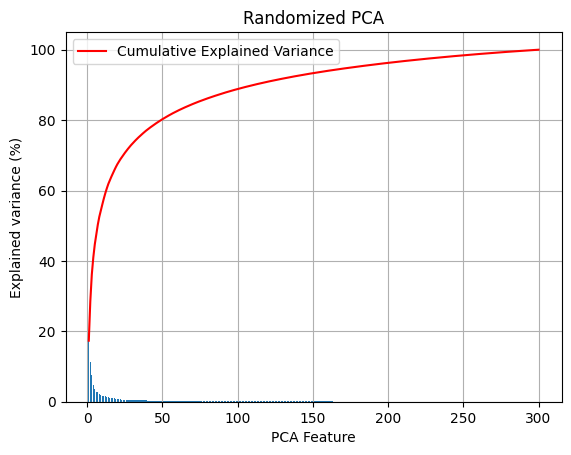

CPU times: user 1min 17s, sys: 7.24 s, total: 1min 24s
Wall time: 12.3 s


In [75]:
%%time
pca_random = PCA(n_components=NUM_COMPONENTS,svd_solver='randomized')
pca_random.fit(scaled)


pca_describer(pca_random,"Randomized PCA")

### Randomized PCA Analysis
We utilized the same number of components as the full PCA to ensure that the algorithms were given a fair benchmark against eachother. According to randomized PCA, the optimal number of components is also about 100. We can see almost the exact same amount of explained variance as the full PCA (This idea will be explored further in the next segment). For the same reasons as the full PCA, we decided that, according to randomized PCA, 100 components is just right because it allows us to get the maximum amount of explained variance while using the fewest number of components.

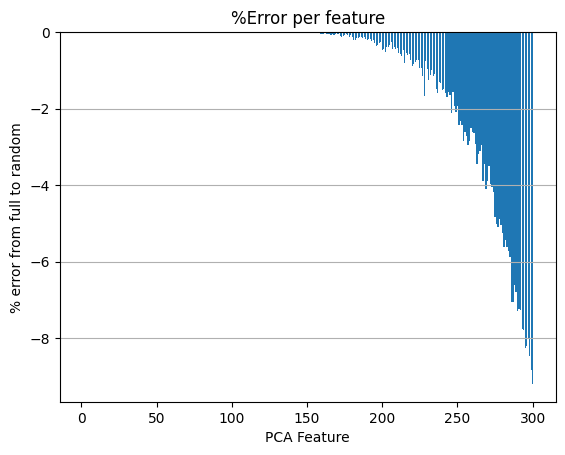

In [76]:
difference = ((pca_random.explained_variance_ - pca_full.explained_variance_) / pca_full.explained_variance_) * 100

plt.bar(range(1,len(difference) + 1),
difference
)

plt.xlabel('PCA Feature')
plt.ylabel('% error from full to random')
plt.title("%Error per feature")

plt.grid(axis='y')
plt.show()



### Comparing Randomized and Full PCA
The graph above shows the percent error with the full PCA being ghe expected value and the randomized PCA being the actual value. As we can see, the randomized PCA was extremely accurate for the first 150 attributes and began to get worse at predicting the explained variance around 225 attributes. By the last attribute, randomized PCA predicted 10% less explained variance than the full PCA did. Randomized PCA also took a fraction of the time that a full PCA did (1/3 on my machine) which makes it capable of doing an analysis on a much larger dataset in the same amount of time as a full PCA can do on a smaller one. Furthermore, since randomized PCA was extremely accurate for the first half of the features and we are trying to determine the fewest number of features necessary to represent the data, the fact that randomized PCA got worse at predicting the values in the 2nd half of the features was of little importance. We determined that randomized PCA is much better than a full PCA because it is accurate where it matters and because it takes signifigantly less time which allows us to run it on a much larger dataset. 

[1 points] Perform feature extraction upon the images using DAISY. Try different parameters for your image data.

[2 points] Does this feature extraction method show promise for your prediction task? Why?
Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

# Feature Extraction

#### To perform DAISY feature extraction, we must reimport our orignal images as a 2D array, which requires that we ignore color data. Then, we should force resize the images to ensure consitent values for the `step` and `radius` fields in DAISY.

/var/folders/rv/0pm7xkrn78b0t6cj8q0391r40000gn/T/ipykernel_20859/2927120769.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dog = np.random.choice(dogs)
/var/folders/rv/0pm7xkrn78b0t6cj8q0391r40000gn/T/ipykernel_20859/2927120769.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(Image.fromarray(dog).convert('L').resize((300,300), Image.ANTIALIAS))


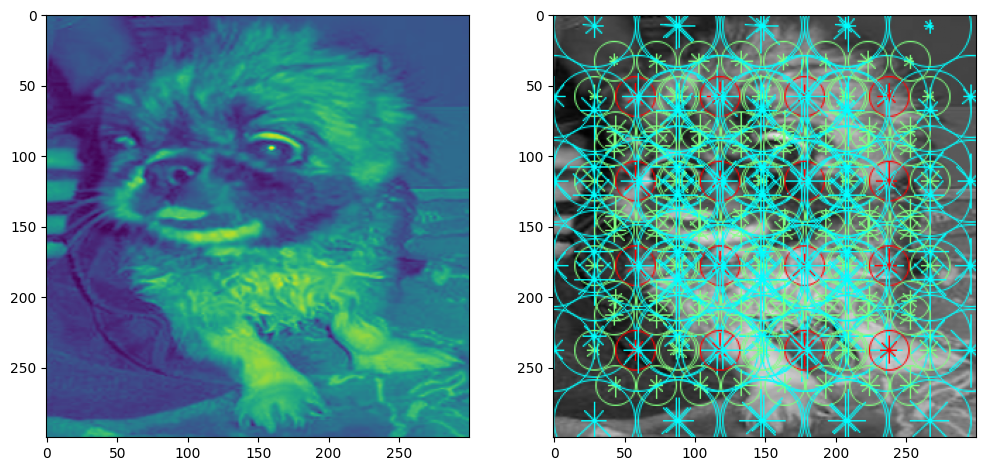

In [77]:
from skimage.feature import daisy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

dog = np.random.choice(dogs)
# using .convert('L') to ignore color data
# resize to consistent size
img = np.array(Image.fromarray(dog).convert('L').resize((300,300), Image.ANTIALIAS))
ax1.imshow(img)

# extract features
descs, descs_img = daisy(img, step=60, radius=58, rings=2, histograms=6,
                        orientations=8, visualize=True)

ax2.imshow(descs_img)
fig.set
plt.show()

#### Let's extract features from a random sample of our dataset and use it to train a simple classifier...

In [78]:
breeds   = []
features = []
targets  = []


for breed in np.random.choice(breed_list, 5):
        print(breed)
        breeds.append(breed)

        for dog in np.random.choice(os.listdir(f'{os.getcwd()}/Images/{breed}'), 50):
                targets.append(breed)

                raw = plt.imread(f'{os.getcwd()}/Images/{breed}/{dog}')
                img = crop_dog(breed, dog.split('.', 1)[0])
                img = np.array(Image.fromarray(img).convert('L').resize((300,300), Image.ANTIALIAS))

                descs = daisy(img, step=60, radius=58, rings=2, histograms=6,
                        orientations=8)

                features.append(descs)
        

n02107312-miniature_pinscher


/var/folders/rv/0pm7xkrn78b0t6cj8q0391r40000gn/T/ipykernel_20859/3035382732.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(Image.fromarray(img).convert('L').resize((300,300), Image.ANTIALIAS))


n02085936-Maltese_dog
n02115913-dhole
n02097047-miniature_schnauzer
n02093647-Bedlington_terrier


In [79]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

X = np.asarray([ft.ravel() for ft in features])

nbrs = KNeighborsClassifier(n_neighbors=5, algorithm='auto').fit(X, targets)
distances, indices = nbrs.kneighbors(X)

g = nbrs.kneighbors_graph(X).toarray()

plt.matshow(distances)

# generate test data from trained breeds
test_features = []
test_labels   = []

for breed in breeds:
    for dog in np.random.choice(os.listdir(f'{os.getcwd()}/Images/{breed}'), 5):
                test_labels.append(breed)
        
                raw = plt.imread(f'{os.getcwd()}/Images/{breed}/{dog}')
                img = crop_dog(breed, dog.split('.', 1)[0])
                img = np.array(Image.fromarray(img).convert('L').resize((300,300), Image.ANTIALIAS))

                descs = daisy(img, step=60, radius=58, rings=2, histograms=6,
                        orientations=8)

                test_features.append(descs)

TEST_X = np.asarray([t_ft.ravel() for t_ft in test_features])
print("K Neighbors Classifier Accuracy:", nbrs.score(TEST_X, test_labels))

# plot_decision_regions(distances, indices, clf=nbrs)


ModuleNotFoundError: No module named 'mlxtend'

#### Using DAISY the classifier only has an accuracy of around 50%. The low accuracy is likely due to the qualify of the images in the dataset, which are highly inconsistent; dogs in the images are in different positions, oritentations, etc., such that features features will not be consistent among breeds. Furthermore, the fact that DAISY requires images to be stripped of color eliminates some of the most distinct features of breeds. For this reason, DAISY does not seem to be a promising method for classifying our dataset of dogs. 

In [ ]:
new_x = []
for val in scaled:
    element = val.reshape(150,150,3)[:,:,0]
    new_x.append(np.ravel(element))
    

new_x = np.array(new_x)
print(new_x.shape)


In [ ]:

# Adapted from Dr. Larson's Notebooks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats




# prepare filter bank kernels
kernels = []
for theta in range(4):# orientations
    theta = theta / 4. * np.pi
    for sigma in (1, 3, 5): # std
        for frequency in (0.05, 0.15, 0.25, 0.35): # frequency
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
# this can be drastically sped up using the 2D FFT
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(new_x))

gabr_feature = compute_gabor(new_x[idx_to_reconstruct], kernels, (150,150))
gabr_feature.shape

NameError: name 'new_x' is not defined

In [ ]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, new_x, kernels, (150,150))
print(gabor_stats.shape)

NameError: name 'new_x' is not defined

NameError: name 'gabor_stats' is not defined

In [ ]:
gab_train, gab_test, y_train, y_test = train_test_split(
    gabor_stats,y,test_size=0.2, train_size=0.8)


print(np.any(np.isnan(gab_train)))
print(np.any(np.isnan(y_train)))
# print(len(gab_train[np.isnan(gab_train)]))

print(np.all(np.isfinite(gab_train)))
print(np.all(np.isfinite(y_train)))

print(len(y[y==1]))
print(len(y[y==0]))

NameError: name 'gabor_stats' is not defined

In [ ]:
knn_gab = KNeighborsClassifier(n_neighbors=1)

knn_gab.fit(gab_train,y_train)
acc_gab = accuracy_score(knn_gab.predict(gab_test),y_test)

print(f"Gabor accuracy: {100*acc_gab:.2f}%")

NameError: name 'gab_train' is not defined

## Gabor Analysis
The Gabor filter analysis had a very low accuracy when classifying the dog breeds. This is due to a couple of factors and ultimately boils down to us not having enough time to run a full model on the entire dataset because it is way too large and would take a long time to run on our computers. One of the biggest reasons that the model was not very good at classifying was that we had to shrink down the training and testing sets signifigantly in order to get the gabor filter to run in a reasonable amount of time. We are only running it on 1000 images and it is taking around 6 mins to run on my machine. One of the ways that we could try to reduce this time would be to shrink the images of the dogs to an even smaller image (right now we are using 150x150) because we could then have a MUCH smaller feature space that needs to be looked at. However, due to time constraints, we were unable to explore such an option. We did explore how the gabor filters would work if we only allowed for 2 dog breeds to be present in the dataset(acheived by removing all but 2 folders from the Images/ folder) and saw that a knn classification with gabor filters had a 95% accuracy when looking only at Borzoi's vs Chihuahuas (a binary classification task).

## Future Use
Overall, Gabor filters seem to be VERY accurate (especially considering that our images were not all the same orientation, some dogs were looking left/right and some were looking directly at the camera), but doing it on a dataset with a large feature size would take a signifigant amount of time. For actual use cases, we determined that if a model wants to be extremely accurate, like if trying to classify the existance of a tumor in a scan, then gabor filters are worth looking into. If the model does not need to be extremely accurate, then it makes more sense to look an alternative because it can be done much faster than a gabor filter.